# Multimodal dataset

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.ndimage import gaussian_filter1d

## Notebook

### Image sample

In [2]:
dset_ls = load_dataset("MultimodalUniverse/legacysurvey",
                       streaming=True,
                       split='train')
dset_ls = dset_ls.with_format("numpy")
dset_iterator = iter(dset_ls)

Resolving data files:   0%|          | 0/165 [00:00<?, ?it/s]

In [3]:
example = next(dset_iterator)

In [4]:
# Let's inspect what is contained in an example
example.keys()

dict_keys(['image', 'blobmodel', 'rgb', 'object_mask', 'catalog', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_I', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2', 'object_id'])

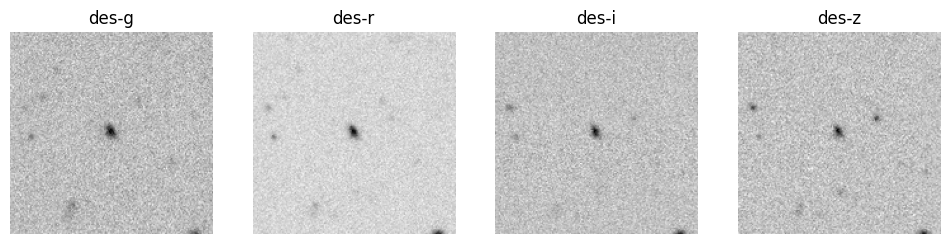

In [5]:
plt.figure(figsize=(12,5))
for i,b in enumerate(example['image']['band']):
  plt.subplot(1,4,i+1)
  plt.title(f'{b}')
  plt.imshow(example['image']['flux'][i], cmap='gray_r')
  plt.axis('off')

### Spectra samples

In [9]:
dset_sdss = load_dataset("MultimodalUniverse/sdss",
                       streaming=True,
                       split='train')
dset_sdss = dset_sdss.with_format("numpy")
dset_iterator = iter(dset_sdss)

In [10]:
example = next(dset_iterator)

In [11]:
# Let's inspect what is contained in an example
example.keys()

dict_keys(['spectrum', 'VDISP', 'VDISP_ERR', 'Z', 'Z_ERR', 'ZWARNING', 'SPECTROFLUX_U', 'SPECTROFLUX_G', 'SPECTROFLUX_R', 'SPECTROFLUX_I', 'SPECTROFLUX_Z', 'SPECTROFLUX_IVAR_U', 'SPECTROFLUX_IVAR_G', 'SPECTROFLUX_IVAR_R', 'SPECTROFLUX_IVAR_I', 'SPECTROFLUX_IVAR_Z', 'SPECTROSYNFLUX_U', 'SPECTROSYNFLUX_G', 'SPECTROSYNFLUX_R', 'SPECTROSYNFLUX_I', 'SPECTROSYNFLUX_Z', 'SPECTROSYNFLUX_IVAR_U', 'SPECTROSYNFLUX_IVAR_G', 'SPECTROSYNFLUX_IVAR_R', 'SPECTROSYNFLUX_IVAR_I', 'SPECTROSYNFLUX_IVAR_Z', 'object_id'])

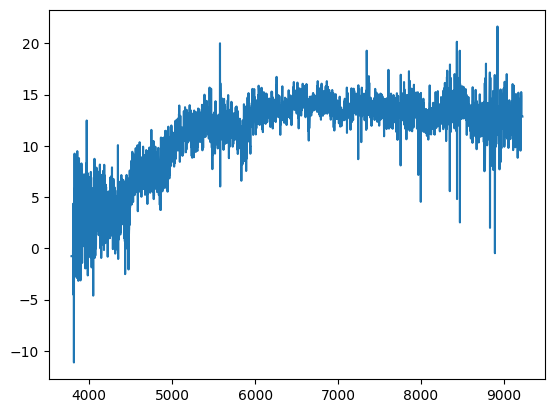

In [12]:
# For plotting, we remove the padding values that are recognizable by the -1
m = example['spectrum']['lambda'] > 0

plt.plot(example['spectrum']['lambda'][m],
     example['spectrum']['flux'][m])

### Times-series

In [13]:
dset_plasticc = load_dataset("MultimodalUniverse/plasticc",
                       streaming=True,
                       split='train')
dset_plasticc = dset_plasticc.with_format("numpy")
dset_iterator = iter(dset_plasticc)

In [14]:
example = next(dset_iterator)
example.keys()

dict_keys(['lightcurve', 'hostgal_photoz', 'hostgal_specz', 'redshift', 'obj_type', 'object_id'])

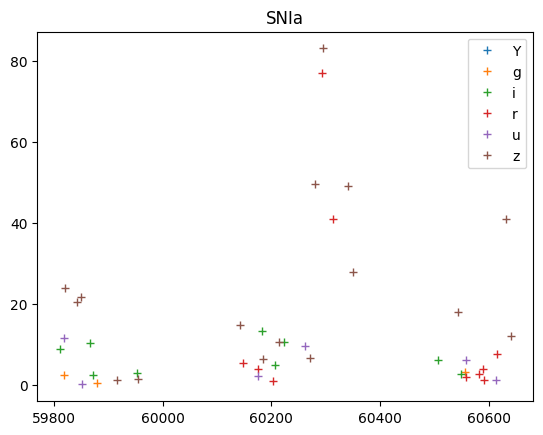

In [15]:
for b in np.unique(example['lightcurve']['band']):
  m = (example['lightcurve']['flux'] > 0) & (example['lightcurve']['band'] == b)
  plt.plot(example['lightcurve']['time'][m],
      example['lightcurve']['flux'][m],'+', label=b)
  plt.title(example['obj_type'])
plt.legend()

### Cross-matching

In [23]:
from datasets import load_dataset_builder
from mmu.utils import cross_match_datasets

In [24]:
# Load the dataset descriptions from local copy of the data
sdss = load_dataset_builder("data/MultimodalUniverse/v1/sdss", trust_remote_code=True)
ls = load_dataset_builder("data/MultimodalUniverse/v1/legacysurvey", trust_remote_code=True)

In [25]:
# Use the cross matching utility to return a new HF dataset, the intersection
# of the parent samples.
dset = cross_match_datasets(sdss, # Left dataset
                            ls,  # Right dataset
                            # matching_radius=1.0, # Distance in arcsec
                            )

Initial number of matches:  335
Number of matches lost at healpix region borders:  0
Final size of cross-matched catalog:  335


In [26]:
# The resulting dataset contains columns from both parent samples
dset

Dataset({
    features: ['spectrum', 'VDISP', 'VDISP_ERR', 'Z', 'Z_ERR', 'ZWARNING', 'SPECTROFLUX_U', 'SPECTROFLUX_G', 'SPECTROFLUX_R', 'SPECTROFLUX_I', 'SPECTROFLUX_Z', 'SPECTROFLUX_IVAR_U', 'SPECTROFLUX_IVAR_G', 'SPECTROFLUX_IVAR_R', 'SPECTROFLUX_IVAR_I', 'SPECTROFLUX_IVAR_Z', 'SPECTROSYNFLUX_U', 'SPECTROSYNFLUX_G', 'SPECTROSYNFLUX_R', 'SPECTROSYNFLUX_I', 'SPECTROSYNFLUX_Z', 'SPECTROSYNFLUX_IVAR_U', 'SPECTROSYNFLUX_IVAR_G', 'SPECTROSYNFLUX_IVAR_R', 'SPECTROSYNFLUX_IVAR_I', 'SPECTROSYNFLUX_IVAR_Z', 'object_id', 'image', 'blobmodel', 'rgb', 'object_mask', 'catalog', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_I', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2'],
    num_rows: 335
})

In [27]:
dset = dset.with_format("numpy")

In [35]:
# Extraire un exemple
example = dset[8]
print(example['spectrum'].keys())
print(example['image'].keys())
print(example['Z'])
print(example['catalog']['FLUX_G'])
print(np.shape(example['image']['flux']))

dict_keys(['flux', 'ivar', 'lsf_sigma', 'lambda', 'mask'])
dict_keys(['band', 'flux', 'mask', 'ivar', 'psf_fwhm', 'scale'])
0.034955595
[  0.6020631   1.2763147   3.7862804   4.303395    3.0967143   3.6337013
 133.33272     0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.       ]
(4, 160, 160)


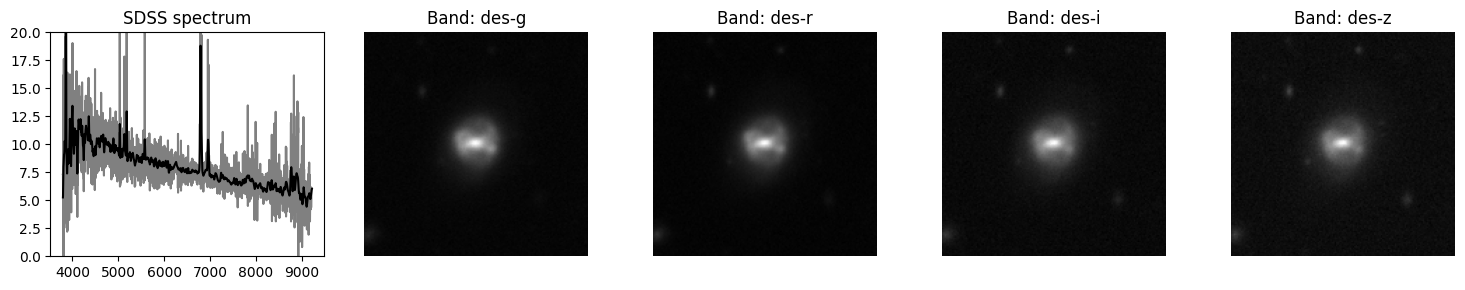

In [29]:
plt.figure(figsize=[15, 3])

# === SDSS spectrum ===
plt.subplot(1, 5, 1)
plt.ylim(0, 20)

# Filtrage pour lambda > 0 (éviter les valeurs invalides)
m = example['spectrum']['lambda'] > 0

# Tracer le spectre brut + version lissée
plt.plot(example['spectrum']['lambda'][m], example['spectrum']['flux'][m], color='gray')
plt.plot(example['spectrum']['lambda'][m],
         gaussian_filter1d(example['spectrum']['flux'], sigma=5)[m],
         color='k')

plt.title("SDSS spectrum")

# === Legacy Survey images ===
for i in range(4):
    plt.subplot(1, 5, i + 2)

    img = example['image']['flux'][i]
    band = example['image']['band'][i]

    # Affichage en échelle log pour mieux voir les contrastes
    plt.imshow(np.log10(img + 2.0), cmap='gray')
    plt.title(f"Band: {band}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## TEST ML

In [42]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [31]:
# # Extraire les colonnes des flux depuis tous les objets
# features = ['FLUX_G', 'FLUX_R', 'FLUX_Z']

# X = pd.DataFrame({
#     'FLUX_G': [obj['catalog']['FLUX_G'] for obj in dset],
#     'FLUX_R': [obj['catalog']['FLUX_R'] for obj in dset],
#     'FLUX_Z': [obj['catalog']['FLUX_Z'] for obj in dset]
# })

# # Extraire les redshifts spectroscopiques (valeurs cibles)
# y = np.array([obj['Z'] for obj in dset])

In [40]:
X_list = []
y_list = []

# On récupère la taille des vecteurs de flux dynamiquement
first_obj = dset[0]
n_flux = len(first_obj['catalog']['FLUX_G'])  # suppose que FLUX_G, R, Z ont la même shape

for obj in dset:
    try:
        fg = obj['catalog']['FLUX_G']
        fr = obj['catalog']['FLUX_R']
        fz = obj['catalog']['FLUX_Z']
        z = obj['Z']
        
        if all(isinstance(f, np.ndarray) and f.shape == (n_flux,) for f in [fg, fr, fz]):
            # Flux
            features = np.concatenate([fg, fr, fz])  # Longueur = 3 * n_flux

            # Couleurs (g - r, r - z, g - z)
            colors = np.concatenate([fg - fr, fr - fz, fg - fz])

            # Log des flux (en ajoutant un epsilon pour éviter log(0))
            log_flux = np.log10(np.concatenate([fg, fr, fz]) + 1e-3)

            all_features = np.concatenate([features, colors, log_flux])  # total = 9 * n_flux

            X_list.append(all_features)
            y_list.append(z)
    except Exception as e:
        print(f"Erreur pour un objet : {e}")

/var/folders/6r/xytwpjy96n11sq02jhw_08_w0000gp/T/ipykernel_48118/337791439.py:23: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(np.concatenate([fg, fr, fz]) + 1e-3)


In [41]:
bands = ['G', 'R', 'Z']
parts = ['flux', 'color', 'log']
X = pd.DataFrame(
    X_list,
    columns=[
        f'{part}_{band}_{i}'
        for part in parts
        for band in bands
        for i in range(n_flux)
    ]
)
y = np.array(y_list)

In [45]:
# suppose que X et y sont déjà construits pour plusieurs objets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"RMSE: {mse ** 0.5:.4f}")

RMSE: 0.1217


In [46]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("Meilleurs hyperparamètres :", grid.best_params_)

# Prédiction avec le meilleur modèle
y_pred_grid = best_model.predict(X_test)
mse_grid = mean_squared_error(y_test, y_pred_grid)
print(f"RMSE optimisé : {mse_grid ** 0.5:.4f}")

Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
RMSE optimisé : 0.1180


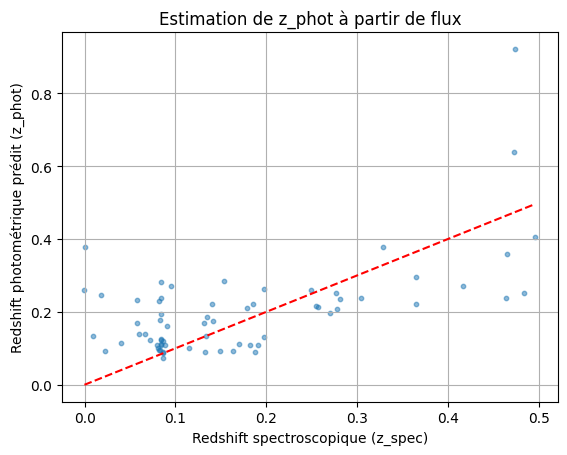

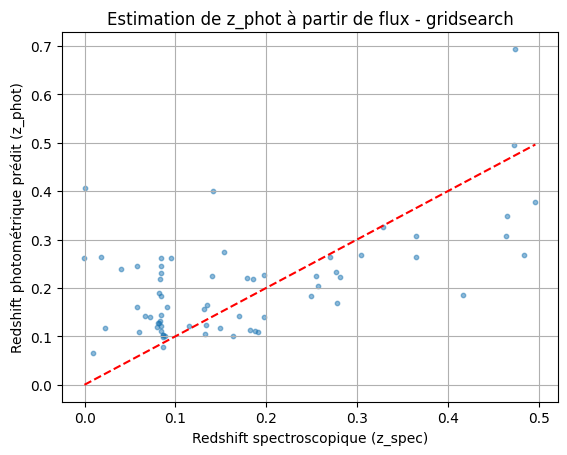

In [47]:
plt.scatter(y_test, y_pred, s=10, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Redshift spectroscopique (z_spec)")
plt.ylabel("Redshift photométrique prédit (z_phot)")
plt.title("Estimation de z_phot à partir de flux")
plt.grid(True)
plt.show()

plt.scatter(y_test, y_pred_grid, s=10, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Redshift spectroscopique (z_spec)")
plt.ylabel("Redshift photométrique prédit (z_phot)")
plt.title("Estimation de z_phot à partir de flux - gridsearch")
plt.grid(True)
plt.show()

# TRASH

In [2]:
# Charger le dataset en streaming (évite de télécharger les 100 TB en local)
dataset = load_dataset("MultimodalUniverse/legacysurvey", split="train", streaming=True)

Resolving data files:   0%|          | 0/165 [00:00<?, ?it/s]

In [4]:
dset_iterator = iter(dataset)
example = next(dset_iterator)

In [5]:
example.keys()

dict_keys(['image', 'blobmodel', 'rgb', 'object_mask', 'catalog', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_I', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2', 'object_id'])

In [6]:
print(example["catalog"])

{'FLUX_G': [1.3640868663787842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'FLUX_R': [2.831369161605835, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'FLUX_I': [4.151123523712158, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'FLUX_Z': [4.814830780029297, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'TYPE': [5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'SHAPE_R': [0.9420995116233826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'SHAPE_E1': [0.23311986029148102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'SHAPE_E2': [-0.33112043142318726, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [7]:
# Extraire les flux des différentes bandes
flux_g = example["catalog"]["FLUX_G"][0]
flux_r = example["catalog"]["FLUX_R"][0]
flux_i = example["catalog"]["FLUX_I"][0]
flux_z = example["catalog"]["FLUX_Z"][0]

# Convertir en magnitudes (m = -2.5 * log10(flux))
mag_g = -2.5 * np.log10(flux_g) if flux_g > 0 else np.nan
mag_r = -2.5 * np.log10(flux_r) if flux_r > 0 else np.nan
mag_i = -2.5 * np.log10(flux_i) if flux_i > 0 else np.nan
mag_z = -2.5 * np.log10(flux_z) if flux_z > 0 else np.nan

# Calculer les couleurs
color_gr = mag_g - mag_r
color_ri = mag_r - mag_i
color_iz = mag_i - mag_z

print(f"g-r: {color_gr}, r-i: {color_ri}, i-z: {color_iz}")

g-r: 0.7928861751385478, r-i: 0.4154228979678214, i-z: 0.16103842865755014


In [8]:
# Estimer le redshift photométrique avec une relation empirique
a, b = 4.0, 0.1  # Coefficients empiriques approximatifs (à ajuster selon la calibration)
photo_z = a * color_gr + b

print(f"Couleur g-r : {color_gr:.3f}")
print(f"Redshift photométrique estimé : {photo_z:.3f}")

Couleur g-r : 0.793
Redshift photométrique estimé : 3.272


In [9]:
# photo_z_list = []
# color_gr_list = []

# for i, sample in enumerate(dataset):
#     try:
#         flux_g = sample["catalog"]["FLUX_G"][0]
#         flux_r = sample["catalog"]["FLUX_R"][0]

#         mag_g = -2.5 * np.log10(flux_g) if flux_g > 0 else np.nan
#         mag_r = -2.5 * np.log10(flux_r) if flux_r > 0 else np.nan

#         color_gr = mag_g - mag_r
#         photo_z = 4.0 * color_gr + 0.1  # Relation empirique

#         photo_z_list.append(photo_z)
#         color_gr_list.append(color_gr)
#     except:
#         continue

#     if i >= 5000:  # Limiter à 5000 objets
#         break

# print(f"Exemples de redshifts photométriques : {photo_z_list[:10]}")

Exemples de redshifts photométriques : [np.float64(3.271544700554191), np.float64(4.880323614590154), np.float64(4.880323614590154), np.float64(4.725182010729297), np.float64(3.9444815145662635), np.float64(2.76844961057723), np.float64(4.660527944260341), np.float64(4.660527944260341), np.float64(6.008726561212286), np.float64(6.008726561212286)]


In [11]:
# Sauvegarde dans un fichier npz
# np.savez("photo_redshifts_5000.npz", redshifts=np.array(photo_z_list), colors=np.array(color_gr_list))
print("Données sauvegardées dans 'photo_redshifts_5000.npz'")

Données sauvegardées dans 'photo_redshifts_5000.npz'


In [15]:
data_ls = np.load('photo_redshifts_5000.npz')
 
photo_z_list = data_ls['redshifts']  
color_gr_list = data_ls['colors'] 

In [16]:
dset_sdss = load_dataset("MultimodalUniverse/sdss", streaming=True, split='train')
dset_sdss = dset_sdss.with_format("numpy")

README.md:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

In [17]:
dset_iterator = iter(dset_sdss)
example = next(dset_iterator)
example.keys()

dict_keys(['spectrum', 'VDISP', 'VDISP_ERR', 'Z', 'Z_ERR', 'ZWARNING', 'SPECTROFLUX_U', 'SPECTROFLUX_G', 'SPECTROFLUX_R', 'SPECTROFLUX_I', 'SPECTROFLUX_Z', 'SPECTROFLUX_IVAR_U', 'SPECTROFLUX_IVAR_G', 'SPECTROFLUX_IVAR_R', 'SPECTROFLUX_IVAR_I', 'SPECTROFLUX_IVAR_Z', 'SPECTROSYNFLUX_U', 'SPECTROSYNFLUX_G', 'SPECTROSYNFLUX_R', 'SPECTROSYNFLUX_I', 'SPECTROSYNFLUX_Z', 'SPECTROSYNFLUX_IVAR_U', 'SPECTROSYNFLUX_IVAR_G', 'SPECTROSYNFLUX_IVAR_R', 'SPECTROSYNFLUX_IVAR_I', 'SPECTROSYNFLUX_IVAR_Z', 'object_id'])

In [19]:
# Stocker les objets matchés
matched_data = []
matching_radius = 1.0 * u.arcsec  # 1 arcsec de tolérance

In [ ]:
# Initialiser les listes pour stocker les résultats
photo_z_list = []
color_gr_list = []

# Charger les données en batchs de 100
for sample in dataset:
    if isinstance(sample, dict) and "catalog" in sample and isinstance(sample["catalog"], dict):
        if "FLUX_G" in sample["catalog"] and "FLUX_R" in sample["catalog"]:
            flux_g = sample["catalog"]["FLUX_G"][0]
            flux_r = sample["catalog"]["FLUX_R"][0]

            if flux_g > 0 and flux_r > 0:  # Vérifier que les flux sont valides
                mag_g = -2.5 * np.log10(flux_g)
                mag_r = -2.5 * np.log10(flux_r)

                color_gr = mag_g - mag_r
                photo_z = 4.0 * color_gr + 0.1  # Relation empirique

                photo_z_list.append(photo_z)
                color_gr_list.append(color_gr)

print(f"Nombre total de redshifts calculés : {len(photo_z_list)}")
print(f"Exemples de redshifts photométriques : {photo_z_list[:10]}")

# Sauvegarde dans un fichier npz
np.savez("photo_redshifts.npz", redshifts=np.array(photo_z_list), colors=np.array(color_gr_list))
print("Données sauvegardées dans 'photo_redshifts.npz'")

## TEST

In [2]:
from datasets import load_dataset_builder
from mmu.utils import cross_match_datasets
import healpy as hp

In [3]:
!/opt/homebrew/bin/wget -r -np -nH --cut-dirs=1 -c -R "index.html*" -q https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/sdss/sdss/healpix=1175/

!/opt/homebrew/bin/wget -r -np -nH --cut-dirs=1 -c -R "index.html*" -q https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/legacysurvey/dr10_south_21/.5/healpix=1175/

!/opt/homebrew/bin/wget -r -np -nH --cut-dirs=1 -R "index.html*" -q https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/sdss/sdss/sdss.py

!/opt/homebrew/bin/wget -r -np -nH --cut-dirs=1 -R "index.html*" -q https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/legacysurvey/legacysurvey.py

In [8]:
nside = 64  # Résolution HEALPix (dépend du dataset)
healpix_index = 1175

# Convertir en coordonnées célestes (longitude/latitude en degrés)
theta, phi = hp.pix2ang(nside, healpix_index, lonlat=True)
ra, dec = theta, phi  # Approximation pour conversion en RA/DEC

print(f"Le HEALPix 1175 correspond à RA={ra:.2f}°, DEC={dec:.2f}°")

Le HEALPix 1175 correspond à RA=268.12°, DEC=72.39°


In [10]:
# Charger les datasets en streaming
sdss = load_dataset_builder("data/MultimodalUniverse/v1/sdss", trust_remote_code=True)
ls = load_dataset_builder("data/MultimodalUniverse/v1/legacysurvey", trust_remote_code=True)

DataFilesNotFoundError: No (supported) data files found in data/MultimodalUniverse/v1/sdss

In [27]:
# Cross-matching avec un rayon de 1 arcsec
cross_matched_dataset = cross_match_datasets(legacy, sdss, matching_radius=1.0, )

AttributeError: 'IterableDataset' object has no attribute 'config'